<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 저혈압 예측 알고리즘

VitalDB 데이터 셋 이용
본 예제에서는 오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요.

## 필요 라이브러리들

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Case Selection

In [4]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # 트랙 목록
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # 임상 정보

caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # caseid를 무작위로 섞음

Total 3452 cases found


## 데이터셋 생성 및 전처리

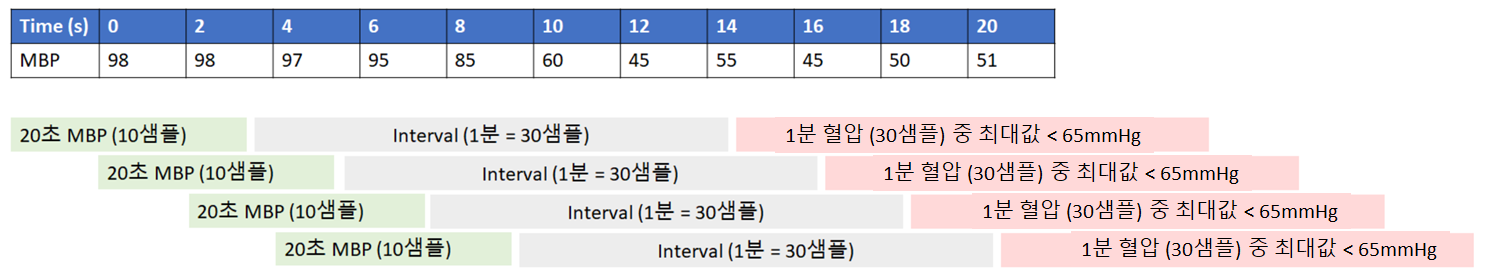

In [6]:
MINUTES_AHEAD = 1  # 저혈압을 1분 전에 예측
LSTM_NODES = 16  # LSTM 내부의 셀 갯수
BATCH_SIZE = 256  # 한번에 처리할 레코드 수 (GPU 메모리 용량에 따라 결정)
MAX_CASES = 100  # 본 예제에서 사용할 최대 case 수

def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtmbps = pd.read_csv(url).values
    except:
        return np.empty(0)
    if len(dtmbps) == 0:
        return np.empty(0)
    dtmbps[:,0] /= interval  # convert time to row
    trklen = int(np.nanmax(dtmbps[:,0])) + 1  # find maximum index (array length)
    ret = np.full(trklen, np.nan)  # create a dense array
    for idx, val in dtmbps:  # copy values
        ret[int(idx)] = val
    return ret

# 최종 생성할 데이터셋
x = []  # 각 레코드의 혈압 시계열 데이터
y = []  # 각 레코드의 출력값 (3분 후 저혈압 발생 여부)
valid_mask = []  # 각 샘플을 학습 및 평가에 사용할지 여부 (유효하지 않은 샘플도 그림을 그리기 위해 필요하기 때문)
y_caseid = []  # 각 레코드의 caseid

# 최대로 로딩할 case 수
ncase = min(MAX_CASES, len(caseids))
icase = 0
for caseid in caseids:
    print('loading {} ({}/{})...'.format(caseid, icase + 1, ncase), flush=True, end='')

    # 현 case의 ART_MBP 트랙의 track id를 구하여 로딩
    tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
    mbps = load_trk(tid, 2)  # 2초 간격으로 혈압을 추출

    # 2시간 이내의 case 들은 사용하지 않음
    if len(mbps) < 360:
        print('case len < 2h')
        continue

    # a-line 연결 전 샘플들을 제거
    with np.errstate(invalid='ignore'):
        mbps[mbps < 40] = np.nan

    # 처음과 마지막의 결측값을 제거
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) != 0) & (np.cumsum(case_valid_mask[::-1])[::-1] != 0)]

    # 중간 결측값을 직전값으로 대체
    mbps = pd.DataFrame(mbps).fillna(method='ffill').values.flatten()
    
    # event data 뽑음
    case_sample = 0
    case_event = 0
    # 입력 혈압 (20초 = 10샘플)
    # 중간 윈도우 (MINUTES_AHEAD * 30 샘플)
    # 결과 혈압 (1분 = 30샘플)
    for i in range(len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]

        # y는 mbp 기준
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # 중간에 nan 있으면?
        valid = True
        if np.any(segx > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(segy > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(np.abs(np.diff(segx)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif np.any(np.abs(np.diff(segy)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif (segx < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False
        elif (segy < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)  # 20초 segment
        y.append(evt)  # 최대 값이 65 미만이어야 함
        valid_mask.append(valid)
        y_caseid.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        icase += 1
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('all nan')

    if icase >= ncase:
        break

# 최종적으로 로딩 된 caseid
caseids = np.unique(y_caseid)

# 입력 데이터셋을 python array 에서 numpy array로 변경
x = np.array(x)[...,None]  # LSTM 에 입력으로 넣으려면 3차원으로 만들어야함
y = np.array(y) 
valid_mask = np.array(valid_mask)
y_caseid = np.array(y_caseid)

loading 5818 (1/100)...1882 samples 418 events (22.2%)
loading 1722 (2/100)...9506 samples 0 events (0.0%)
loading 4975 (3/100)...7480 samples 14 events (0.2%)
loading 742 (4/100)...6971 samples 144 events (2.1%)
loading 5460 (5/100)...2117 samples 133 events (6.3%)
loading 1145 (6/100)...7907 samples 0 events (0.0%)
loading 3757 (7/100)...4486 samples 195 events (4.3%)
loading 589 (8/100)...3747 samples 17 events (0.5%)
loading 483 (9/100)...all nan
loading 4653 (9/100)...6114 samples 1109 events (18.1%)
loading 1662 (10/100)...2595 samples 0 events (0.0%)
loading 1566 (11/100)...5605 samples 333 events (5.9%)
loading 2340 (12/100)...7702 samples 142 events (1.8%)
loading 3161 (13/100)...3914 samples 116 events (3.0%)
loading 1921 (14/100)...all nan
loading 283 (14/100)...6330 samples 75 events (1.2%)
loading 3075 (15/100)...7111 samples 75 events (1.1%)
loading 3103 (16/100)...6391 samples 0 events (0.0%)
loading 1089 (17/100)...5248 samples 0 events (0.0%)
loading 5195 (18/100)...34

## Training / Testing set 으로 나눔

In [7]:
# train, test set 을 case 단위로 나눔
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.array([caseid in caseids_train for caseid in y_caseid])
test_mask = np.array([caseid in caseids_test for caseid in y_caseid])

# test set은 그림을 그려야 하므로 invalid 값까지 전체 데이터도 필요
test_x = x[test_mask]
test_y = y[test_mask]
test_y_caseid = y_caseid[test_mask]

# valid 한 값만 포함하는 배열 (학습 및 성능 평가시 사용)
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 548462, train 416397 (12346 events 3.0%), test 103060 (8584 events 8.3%)'

## 모델 생성 및 학습 시작

In [8]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# 임시 폴더를 생성
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# 최적의 모델을 저장
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1464/1464 [==============================] - 14s 8ms/step - loss: 0.2095 - accuracy: 0.9557 - auc: 0.9583 - val_loss: 0.1879 - val_accuracy: 0.9197 - val_auc: 0.9750

Epoch 00001: val_loss improved from inf to 0.18788, saving model to output/weights.hdf5
Epoch 2/100
1464/1464 [==============================] - 11s 7ms/step - loss: 0.1539 - accuracy: 0.9653 - auc: 0.9714 - val_loss: 0.0703 - val_accuracy: 0.9746 - val_auc: 0.9738

Epoch 00002: val_loss improved from 0.18788 to 0.07034, saving model to output/weights.hdf5
Epoch 3/100
1464/1464 [==============================] - 11s 7ms/step - loss: 0.1524 - accuracy: 0.9651 - auc: 0.9716 - val_loss: 0.0591 - val_accuracy: 0.9750 - val_auc: 0.9736

Epoch 00003: val_loss improved from 0.07034 to 0.05908, saving model to output/weights.hdf5
Epoch 4/100
1464/1464 [==============================] - 11s 7ms/step - loss: 0.1517 - accuracy: 0.9645 - auc: 0.9718 - val_loss: 0.0635 - val_accuracy: 0.9754 - val_auc: 0.9738

Epoch 00004:

2125

## 모델 성능 평가

In [11]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# test을 한번에 예측
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# 최종 폴더명을 변경
odir = testname + ' ' + testres
os.rename(tempdir, odir)

auroc=0.950, auprc=0.585 acc=0.931, F1=0.505, PPV=62.9, NPV=94.9, TN=92340, fp=2136, fn=4959, TP=3625


## 그래프 그림

4764	0.09279031098160122	


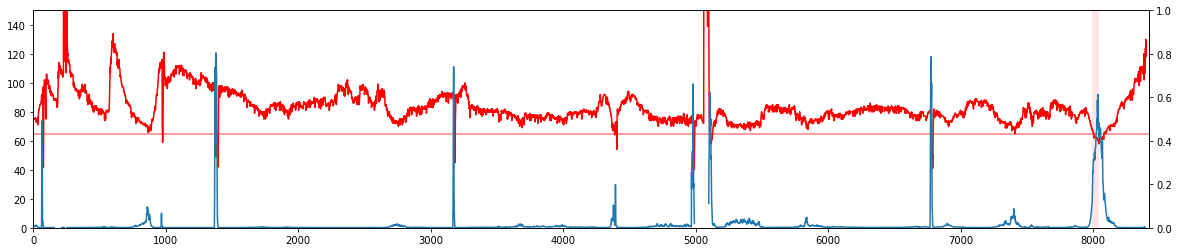

4778	0.31843489938784	


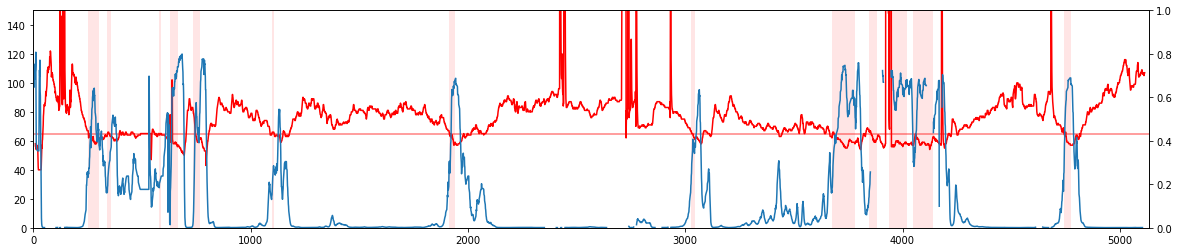

4831	0.25209795315701056	


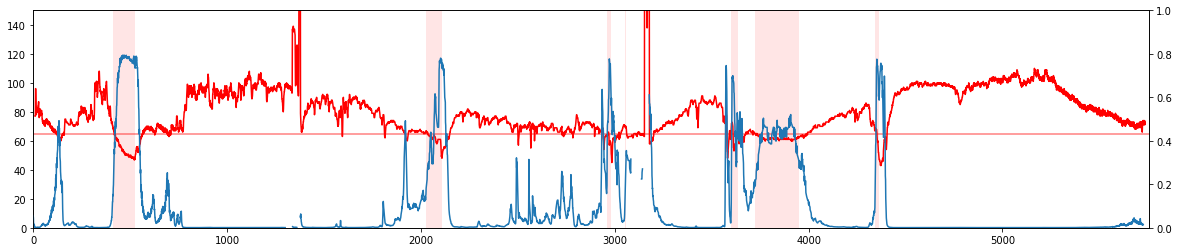

4876	0.00360700025743129	


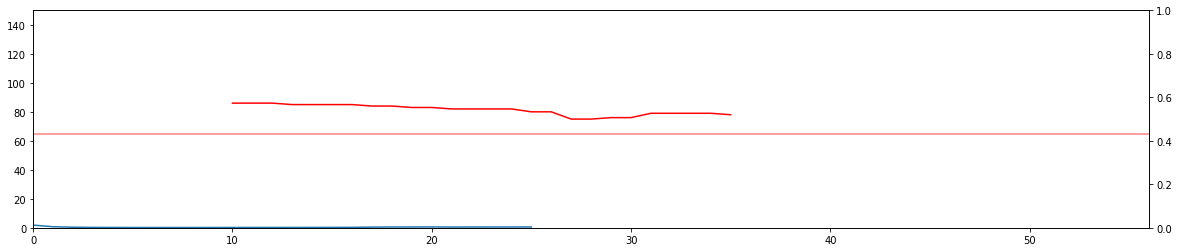

4975	0.057635361019780784	


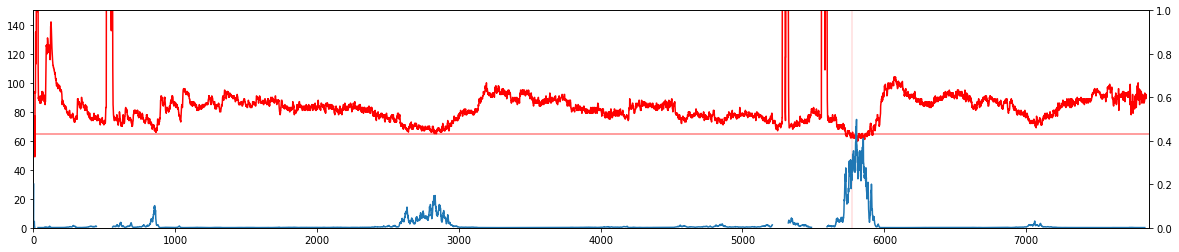

5195	0.13597256164451052	


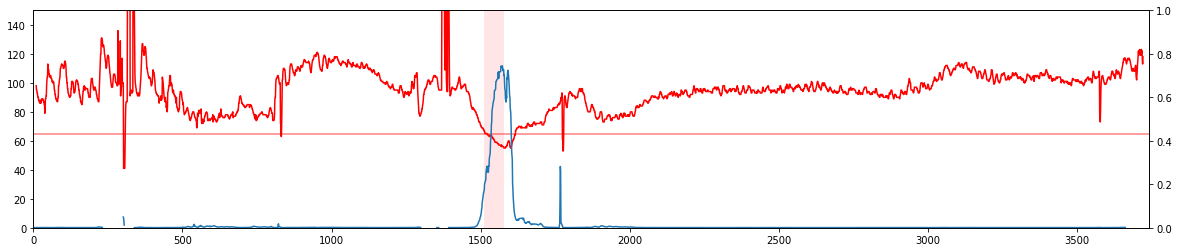

5204	0.2635377330762895	


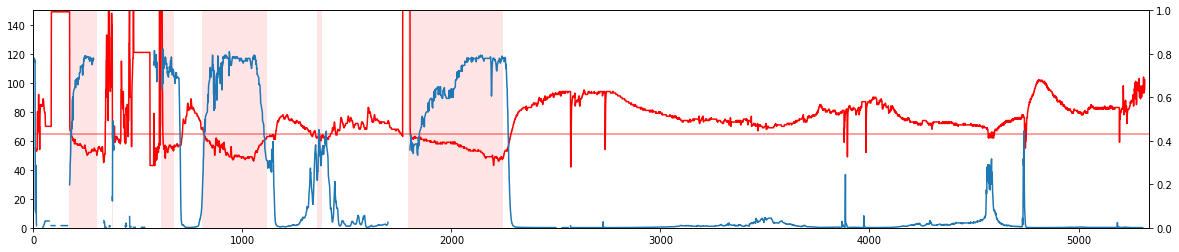

5394	0.11032016273662883	


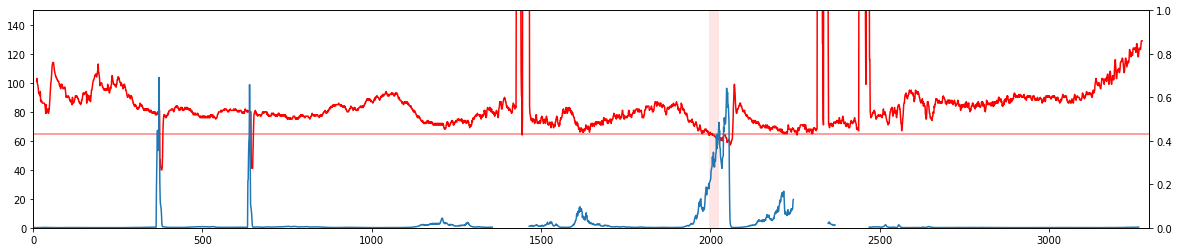

5460	0.2553499260438999	


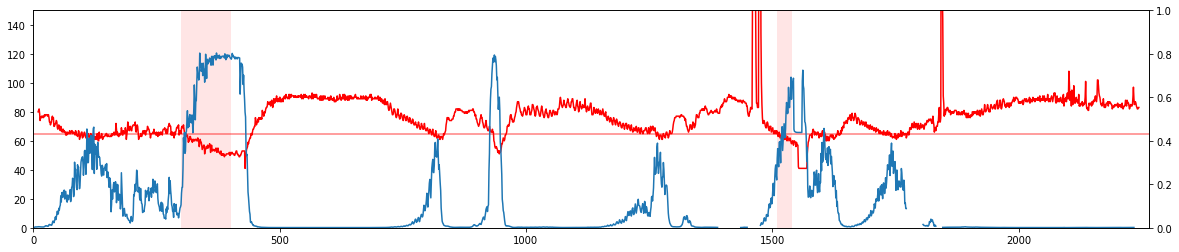

5497	0.23370476097528486	


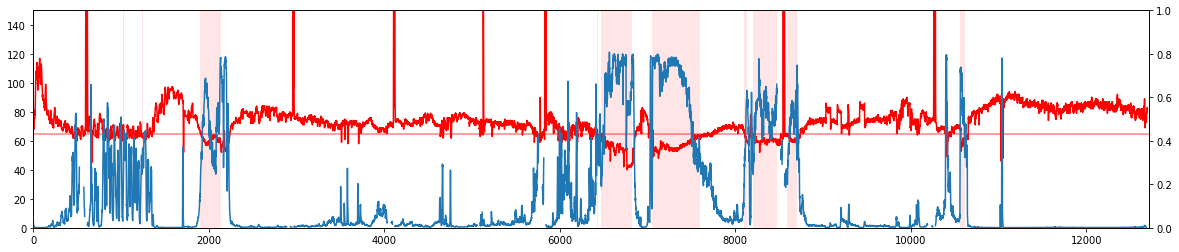

5587	0.37494450396930157	


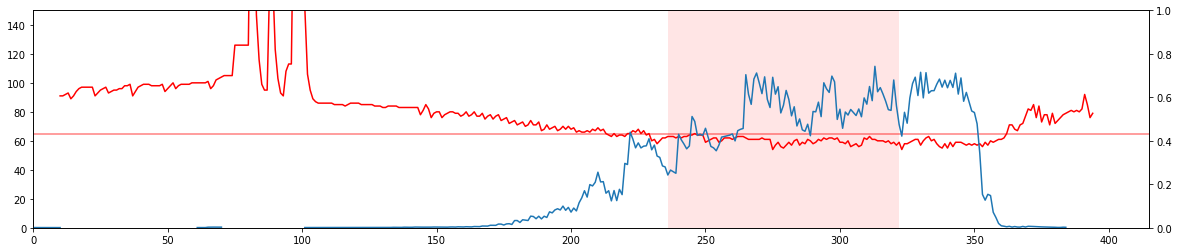

5603	0.2120616416542767	


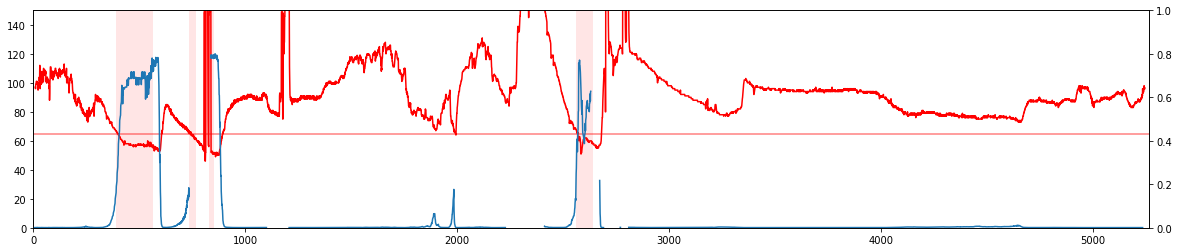

5665	0.05595005126679439	


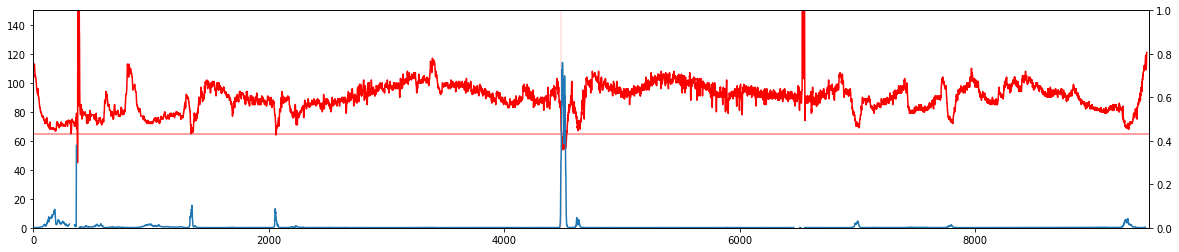

5818	0.3415105001474596	


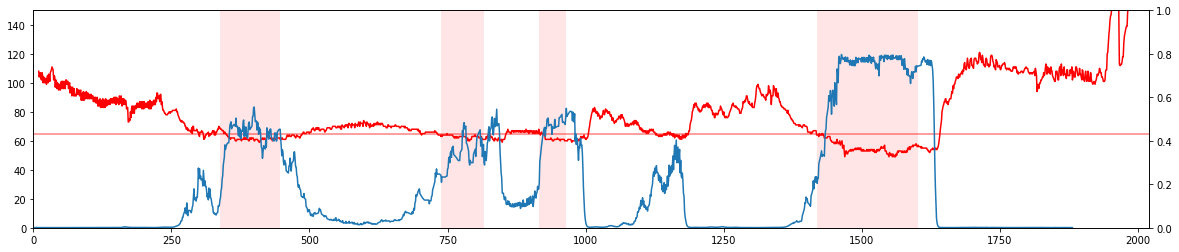

5914	0.20683103452928386	


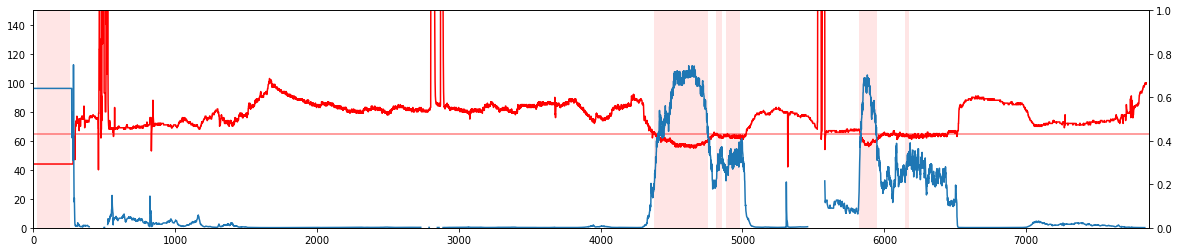

5951	0.011718110474381729	


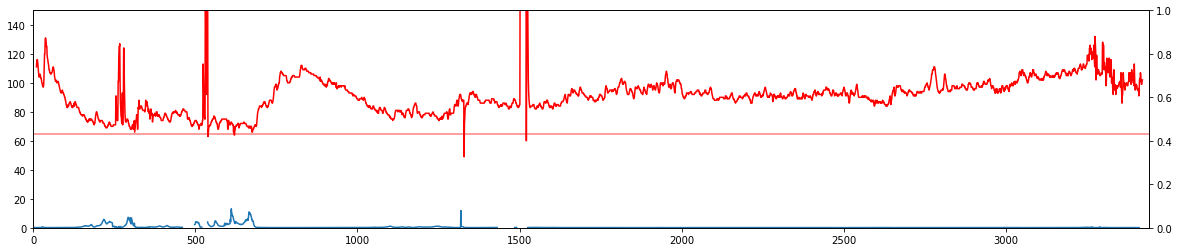

5956	0.22373750060348047	


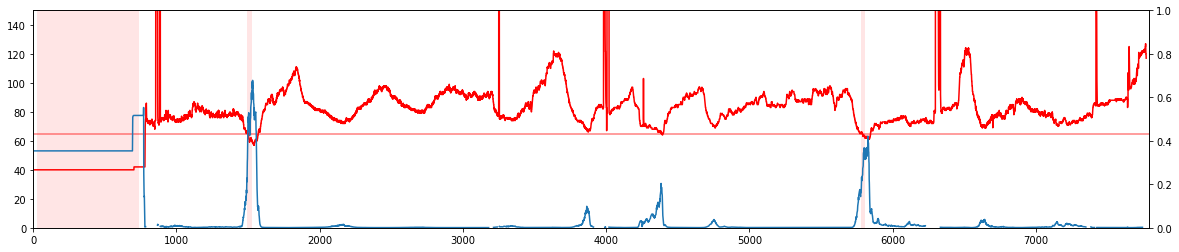

6042	0.19754754118990717	


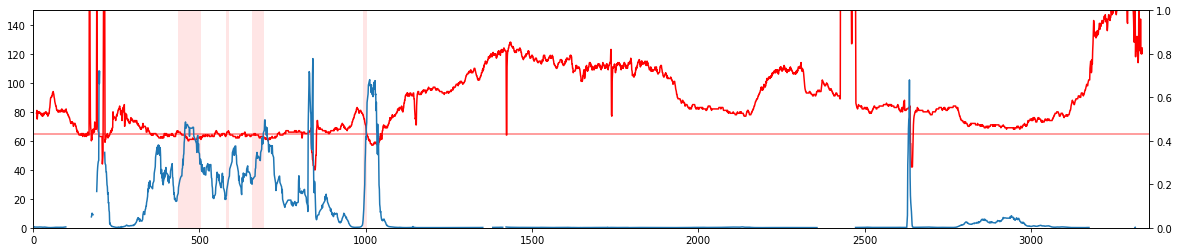

6114	0.33716293210104553	


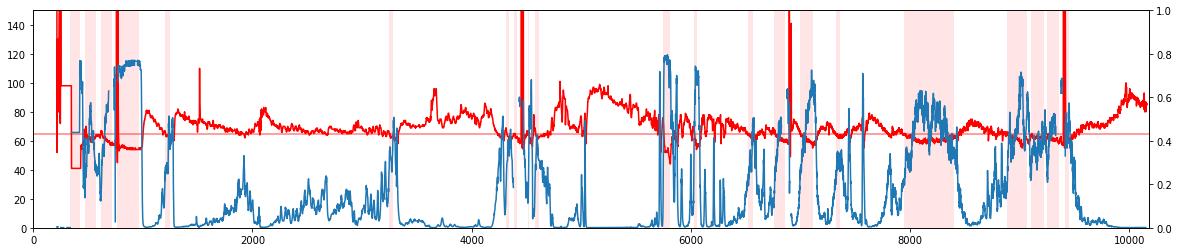

6133	0.17577235411280392	


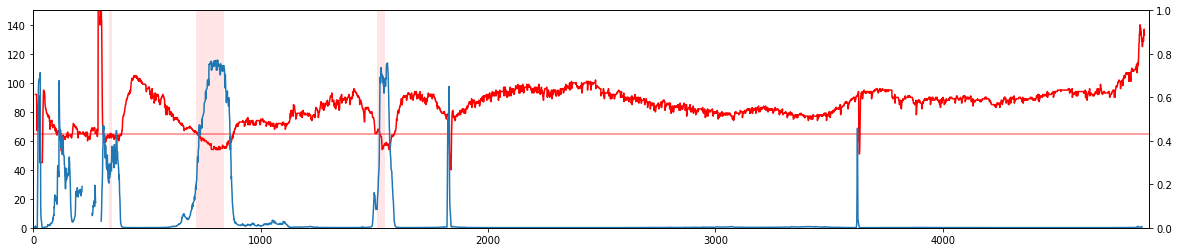

In [13]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

# 각 case 그림
for caseid in caseids_test:
    case_mask = (y_caseid == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    # case 내의 x, y, valid_mask 를 만든다
    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # case 에러를 구하고 출력
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # 그림 생성
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # 저혈압 상태일 때를 붉은 반투명 배경으로
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg 가로선
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # valid 한 샘플만 그린다
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # 그림 저장
    plt.show()